In [2]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [3]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

img_names = test['img_names']

In [4]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [5]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [6]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [7]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [8]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [9]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-06-19 11:56:40.413455: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 11:56:40.414586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 11:56:40.439088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow w

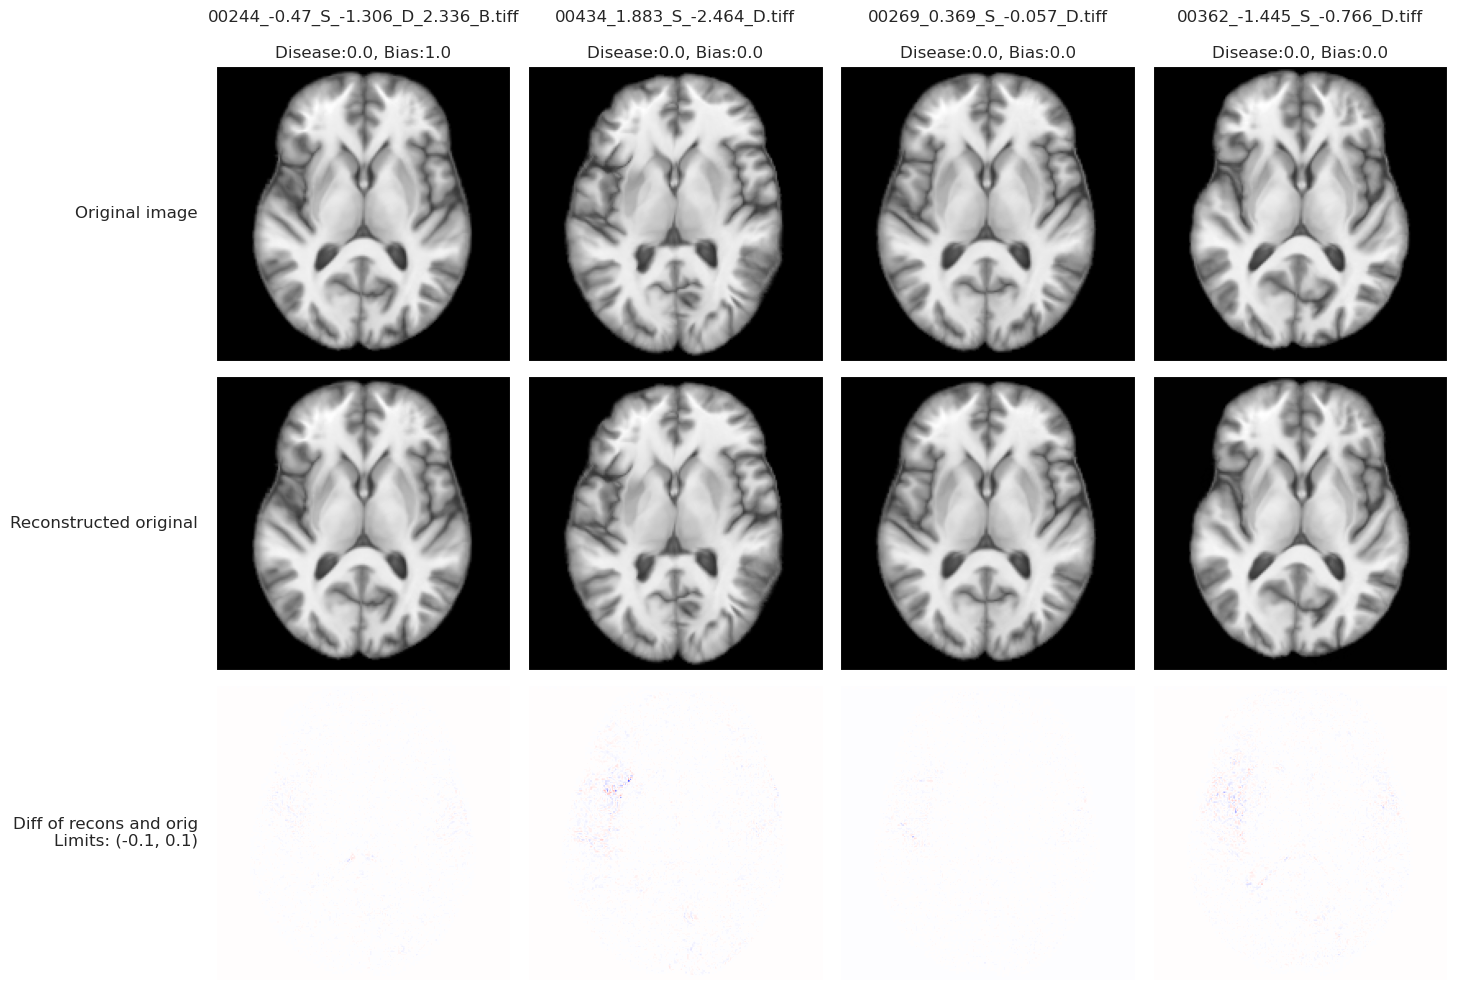

In [59]:
import textwrap
import SimpleITK as sitk
import numpy as np
import torch

save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:0}
nsamples = 4
image_shape = (180, 180)  # Assuming each image is 180x180

rands = np.random.randint(0, encoded_data.shape[0], nsamples)
d_obs = test_imgs[rands, :]
encoded_obs = encoded_data[rands, :]

names = img_names[rands]
dis_obs = disease[rands]
bias_obs = bias[rands]
residuals = d_obs - pca.inverse_transform(encoded_obs)

cf = np.zeros((nsamples, ncomps))
for ev in range(0, ncomps - nbasecomps, nevecs - nbasecomps):
    ed = encoded_obs[:, ev:ev + nevecs]
    X_obs = np.hstack([dis_obs[:, np.newaxis], bias_obs[:, np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path / f'{ev}.pt')
        cc = macaw.counterfactual(X_obs, cf_vals)
    except Exception as e:
        print(e, "Using original")
        cc[:, ncauses:] = X_obs[:, ncauses:].copy()

    cf[:, ev:ev + nevecs] = cc[:, ncauses:]

re_cf = recons(cc[:, 0], cc[:, 1], cf)
re_cf_resd = re_cf[2] + residuals

# Convert numpy arrays to SimpleITK images
def numpy_to_sitk(img):
    return sitk.GetImageFromArray(img.astype(np.float32))

def sitk_to_numpy(img):
    return sitk.GetArrayFromImage(img)

# Perform histogram matching
matched_images = []
for i in range(nsamples):
    # Reshape the arrays to 2D images
    source_img_2d = re_cf_resd[i].reshape(image_shape).astype(np.float32)
    reference_img_2d = d_obs[i].reshape(image_shape).astype(np.float32)

    source_img = numpy_to_sitk(source_img_2d)
    reference_img = numpy_to_sitk(reference_img_2d)

    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(500)
    matcher.SetNumberOfMatchPoints(50)
    matcher.SetThresholdAtMeanIntensity(False)
    matched_img = matcher.Execute(source_img, reference_img)

    # Convert the matched image back to a numpy array and reshape to original shape
    matched_img_array = sitk_to_numpy(matched_img).reshape(-1)
    matched_images.append(matched_img_array)

# Convert the matched images back to a numpy array
re_cf_resd = np.array(matched_images)

# Ensuring values are still in the range [0, 1] after histogram matching
re_cf_resd = np.clip(re_cf_resd, 0, 1)

t = pca.transform(d_obs)
X_recon = pca.inverse_transform(t)
diff2 = d_obs - X_recon

diff = d_obs - re_cf_resd

fig,axs = plt.subplots(3,nsamples, figsize=(15,10))

lim=.1
lims=(-lim,lim)

for i in range(nsamples):
    axs[0,i].imshow(d_obs[i].reshape(crop_size,crop_size),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'{names[i]}\n\nDisease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

    # axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
    # axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}')
    # 
    # axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    # axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # reconstruction
    axs[1,i].imshow(X_recon[i].reshape(crop_size,crop_size),cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # reconstruction error, should be zero
    axs[2,i].imshow(diff2[i].reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # cf changes with PCA changes removed
    # axs[5,i].imshow((diff[i]-diff2[i]).reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    # axs[5,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
# labels = ['Original image', 'Counterfactual image', 'Diff of Original and CF', 'Reconstructed original', 'Diff of recons and orig', 'Diff of diffs']
labels = ['Original image', 'Reconstructed original', f'Diff of recons and orig\nLimits: {lims}']
# wrapped_labels = [textwrap.fill(label, width=15) for label in labels] 
    
# Add labels to the left side of each row
for ax, label in zip(axs[:, 0], labels):
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.15)  # Adjust to make room for the labels
    
if not os.path.exists(save_name):
    os.makedirs(save_name)

plt.savefig(save_name+f"cf1.pdf")
plt.show()